# pit-perfect

The following notebook provides the cleaned and usable datasets used within `main.ipynb`.

## 1. Circuit Lap & Weather Data

### 1.1 Import Libraries

In [122]:
# Import libraries
import pandas as pd
import requests
from datetime import datetime
import json

### 1.2 Extract Lap Times
As the weather API has no lap-by-lap data, we need to do this manually and map to each lap time. As for the lap data, there is no API which provides time stamps for each lap start time, so we will extract these from the lap data ourselves. Fortunately, this is quite simple to do. In a race, the leader determines when the next lap starts, so all we need to do is for each lap, find the earliest time, and this is the time that lap begun. From there we will approximate to the weather data the closest time and connect these features to provide approximate lap-by-lap weather.

In [123]:
# Get meeting and session details for British Grand Prix 2025
location = "United Kingdom"
year = 2025
url = f"https://api.openf1.org/v1/sessions?country_name={location}&session_name=Race&year={year}"
session_details_response = requests.get(url).json()
meeting = session_details_response[0]["meeting_key"]
session = session_details_response[0]["session_key"]
print(f"Meeting Key ({meeting}), Session Key ({session})")


Meeting Key (1277), Session Key (9947)


In [124]:
# Get raw lap data
url = f"https://api.openf1.org/v1/laps?session_key={session}"
lap_data_response = requests.get(url).json()
laps_df = pd.DataFrame(lap_data_response)
print(laps_df.dtypes)
print(laps_df.shape)
laps_df.head(n=3)

meeting_key            int64
session_key            int64
driver_number          int64
lap_number             int64
date_start            object
duration_sector_1    float64
duration_sector_2    float64
duration_sector_3    float64
i1_speed             float64
i2_speed             float64
is_pit_out_lap          bool
lap_duration         float64
segments_sector_1     object
segments_sector_2     object
segments_sector_3     object
st_speed             float64
dtype: object
(827, 16)


,meeting_key,session_key,driver_number,lap_number,date_start,duration_sector_1,duration_sector_2,duration_sector_3,i1_speed,i2_speed,is_pit_out_lap,lap_duration,segments_sector_1,segments_sector_2,segments_sector_3,st_speed
0,1277,9947,1,1,2025-07-06T14:03:49.615000+00:00,35.506,41.707,28.921,299.0,242.0,False,106.134,"[2048, 2051, 2051, 2051, 2051, 2049, 2049]","[2049, 2049, 2049, 2049, 2051, 2049, 2049, 204...","[2049, 2049, 2049, 2049, 2049, 2049, 2051, 204...",304.0
1,1277,9947,81,1,2025-07-06T14:03:49.615000+00:00,36.513,41.490,28.951,298.0,243.0,False,106.954,"[2048, 2049, 2049, 2049, 2049, 2049, 2049]","[2051, 2051, 2049, 2051, 2049, 2051, 2051, 204...","[2049, 2049, 2049, 2049, 2051, 2049, 2049, 205...",298.0
2,1277,9947,4,1,2025-07-06T14:03:49.615000+00:00,36.706,42.322,29.525,295.0,231.0,False,108.553,"[2048, 2049, 2049, 2049, 2049, 2051, 2049]","[2049, 2049, 2049, 2049, 2049, 2049, 2049, 204...","[2049, 2049, 2049, 2051, 2049, 2049, 2049, 204...",299.0


In [125]:
# Before we continue, let's adjust the date_start attribute to a datetime object.
laps_df['date_start'] = pd.to_datetime(laps_df['date_start'])

# We can also drop a few features that won't be relevant to our investigation.
to_drop = ['meeting_key', 'session_key', 'driver_number', 'duration_sector_1', 'duration_sector_2', 'duration_sector_3', 'i1_speed', 'i2_speed', 'segments_sector_1', 'segments_sector_2', 'segments_sector_3', 'is_pit_out_lap', 'lap_duration', 'st_speed']
laps_df.drop(columns=to_drop, inplace=True)

print(laps_df.dtypes)

lap_number                  int64
date_start    datetime64[ns, UTC]
dtype: object


In [126]:
# Now that we have lap data, we need to for each lap_number, only take the earliest date_start. The race leader determines what lap we are on, so this gives us the date_start for each lap.
lap_start_indices = laps_df.groupby('lap_number')['date_start'].idxmin()
laps_df = laps_df.loc[lap_start_indices]

# Let's also make sure that each lap looks okay.
print(laps_df.isna().sum())
print(laps_df['lap_number'].unique())
print(f"# of laps: {len(laps_df['lap_number'].unique())}")
print(laps_df.head(n=3))
print(laps_df.tail(n=3))

# Sanity check for total race time
duration = laps_df['date_start'].iloc[-1] - laps_df['date_start'].iloc[0]
print(f"race duration: {duration}")


lap_number    0
date_start    0
dtype: int64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
# of laps: 52
    lap_number                       date_start
0            1 2025-07-06 14:03:49.615000+00:00
20           2 2025-07-06 14:05:35.748000+00:00
38           3 2025-07-06 14:07:51.342000+00:00
     lap_number                       date_start
782          50 2025-07-06 15:36:34.809000+00:00
797          51 2025-07-06 15:38:04.836000+00:00
812          52 2025-07-06 15:39:35.040000+00:00
race duration: 0 days 01:35:45.425000


So we have each lap and the times look good. The race finished at 1:37:15.735 according to [formula1.com](https://www.formula1.com/en/results/2025/races/1277/great-britain/race-result).
We can now move onto preparing the weather data.

### 1.3 Retrieve Weather Data

In [127]:
# Now we can query for the weather data during the event
url = f"https://api.openf1.org/v1/weather?meeting_key={meeting}&session_key={session}"
response = requests.get(url).json()
weather_df = pd.DataFrame(response)
print(weather_df.dtypes)
print(weather_df.shape)
weather_df.head(n=3)

date                  object
session_key            int64
meeting_key            int64
rainfall               int64
wind_direction         int64
wind_speed           float64
pressure             float64
air_temperature      float64
humidity             float64
track_temperature    float64
dtype: object
(155, 10)


,date,session_key,meeting_key,rainfall,wind_direction,wind_speed,pressure,air_temperature,humidity,track_temperature
0,2025-07-06T13:08:00.335000+00:00,9947,1277,0,174,0.7,988.6,18.0,85.0,24.2
1,2025-07-06T13:09:00.287000+00:00,9947,1277,0,111,0.9,988.5,18.0,83.0,24.6
2,2025-07-06T13:10:00.295000+00:00,9947,1277,0,61,2.2,988.6,18.1,82.0,24.6


In [128]:
# Before continuing, let's drop a few features we will not need.
to_drop = ['session_key', 'meeting_key', 'pressure']
weather_df.drop(columns=to_drop, inplace=True)

# Let's also move the air temp next to track temp
temp = weather_df.pop('air_temperature')
weather_df['air_temperature'] = temp

# Now we can adjust the date to a datetime object.
weather_df['date'] = pd.to_datetime(weather_df['date'])
print(weather_df.dtypes)
print(weather_df.shape)
weather_df.head(n=3)

date                 datetime64[ns, UTC]
rainfall                           int64
wind_direction                     int64
wind_speed                       float64
humidity                         float64
track_temperature                float64
air_temperature                  float64
dtype: object
(155, 7)


,date,rainfall,wind_direction,wind_speed,humidity,track_temperature,air_temperature
0,2025-07-06 13:08:00.335000+00:00,0,174,0.7,85.0,24.2,18.0
1,2025-07-06 13:09:00.287000+00:00,0,111,0.9,83.0,24.6,18.0
2,2025-07-06 13:10:00.295000+00:00,0,61,2.2,82.0,24.6,18.1


In [129]:
# Now some sanity checks to ensure the dataframe looks ok.
print(weather_df.describe())
print(weather_df.isna().sum())

         rainfall  wind_direction  wind_speed    humidity  track_temperature  \
count  155.000000      155.000000  155.000000  155.000000         155.000000   
mean     0.180645      139.006452    1.483226   78.374194          23.578710   
std      0.385971      108.855528    0.863158    6.133947           1.507513   
min      0.000000        0.000000    0.000000   63.000000          20.000000   
25%      0.000000       59.500000    0.900000   74.000000          22.800000   
50%      0.000000       87.000000    1.200000   80.000000          23.600000   
75%      0.000000      254.000000    1.900000   83.000000          24.400000   
max      1.000000      352.000000    5.800000   88.000000          29.600000   

       air_temperature  
count       155.000000  
mean         17.917419  
std           0.895091  
min          16.000000  
25%          17.250000  
50%          18.000000  
75%          18.600000  
max          19.600000  
date                 0
rainfall             0
wind_dir

Everything looks good. We are now ready to combine our lap data with our weather.

### 1.4 Combine Lap & Weather Data

In [130]:
# Begin the merge
lap_weather_df = pd.merge_asof(
    laps_df,
    weather_df,
    left_on='date_start',
    right_on='date',
    direction='nearest'
)

# Lets quickly rename the weather date for clarity
lap_weather_df.rename(columns={'date': 'weather_date'}, inplace=True)

# Create two new features to see how the track and air temp delta
lap_weather_df['track_temp_delta'] = lap_weather_df['track_temperature'].diff()
lap_weather_df['air_temp_delta'] = lap_weather_df['air_temperature'].diff()

# We will get NaN for the first row for the deltas, so lets fill those.
lap_weather_df = lap_weather_df.fillna(0)

lap_weather_df.head(15)

,lap_number,date_start,weather_date,rainfall,wind_direction,wind_speed,humidity,track_temperature,air_temperature,track_temp_delta,air_temp_delta
0,1,2025-07-06 14:03:49.615000+00:00,2025-07-06 14:04:00.459000+00:00,0,0,0.9,80.0,24.1,18.3,0.0,0.0
1,2,2025-07-06 14:05:35.748000+00:00,2025-07-06 14:06:00.477000+00:00,0,8,1.0,82.0,24.5,18.5,0.4,0.2
2,3,2025-07-06 14:07:51.342000+00:00,2025-07-06 14:08:00.492000+00:00,0,66,1.5,80.0,24.5,18.4,0.0,-0.1
3,4,2025-07-06 14:10:08.854000+00:00,2025-07-06 14:10:00.511000+00:00,0,332,1.1,78.0,24.8,18.6,0.3,0.2
4,5,2025-07-06 14:11:54.438000+00:00,2025-07-06 14:12:00.523000+00:00,0,313,0.9,75.0,24.9,18.6,0.1,0.0
5,6,2025-07-06 14:13:39.322000+00:00,2025-07-06 14:14:00.544000+00:00,0,93,1.2,77.0,25.2,18.8,0.3,0.2
6,7,2025-07-06 14:15:59.029000+00:00,2025-07-06 14:16:00.558000+00:00,0,82,1.3,75.0,24.4,19.1,-0.8,0.3
7,8,2025-07-06 14:18:01.513000+00:00,2025-07-06 14:18:00.560000+00:00,0,186,1.1,74.0,24.0,19.2,-0.4,0.1
8,9,2025-07-06 14:19:46.268000+00:00,2025-07-06 14:20:00.556000+00:00,0,238,1.1,74.0,24.8,19.2,0.8,0.0
9,10,2025-07-06 14:21:30.802000+00:00,2025-07-06 14:22:00.591000+00:00,0,29,1.9,72.0,24.3,19.2,-0.5,0.0


In [131]:
# Now let's create a temporary feature to inspect the weather data
lap_weather_df['time_diff'] = lap_weather_df['date_start'] - lap_weather_df['weather_date']
lap_weather_df['time_diff'] = lap_weather_df['time_diff'].dt.total_seconds()
lap_weather_df['time_diff'].describe()

count    52.000000
mean     -4.973308
std      16.074172
min     -29.789000
25%     -19.546500
50%      -5.069000
75%       7.285750
max      29.756000
Name: time_diff, dtype: float64

Looking at our date_diff the weather events look pretty close to the lap start time for the most part. With an IQR or -19s to 7s we can be happy with the relative lap-by-lap weather accuracy.
We can now move onto getting the lap information for each driver.

## 2. Driver's Stint & Lap Info

Now that we have the track and weather data, we can now extract Nico's lap times and stint information, as well as a few other drivers to draw comparisons later.

We're going to take a look at a few other drivers strategy choices during the race to see how they compared with Nico's race.

1. Lance Stroll (Benchmark)
    * Reasonably similar starting position, similar to Nico
    * Cruised P18 -> P7
    
2. Lewis Hamilton (Front-runner)
    * Started front of grid, maintained position, still overtaken by Nico
    * Gained P5 -> P4

3. George Russel (Gambler)
    * Gambled early to get off wets, largely incorrect call
    * Tumbled P4 -> P10

These comparative strategies will give as an idea of how good/lucky Nico's race really was.

In [132]:
# Nico Hulkenberg #27, Lance Stroll #18, Lewis Hamilton #44, George Russel #63
drivers = [27, 18, 44, 63]

### 2.1. Driver's Lap Info

In [147]:
# First, let's grab driver data. Driver numbers for reference below.
all_data = []

for driver_number in drivers:
    url = f'https://api.openf1.org/v1/laps?session_key={session}&driver_number={driver_number}'
    response = requests.get(url).json()    
    all_data.extend(response)

In [148]:
# Convert responses to DataFrame
driver_laps_df = pd.DataFrame(all_data)
driver_laps_df.describe()

# Drop irrelevant features
to_drop = ['meeting_key', 'session_key', 'date_start', 'duration_sector_1', 'duration_sector_2', 'duration_sector_3', 'is_pit_out_lap', 'segments_sector_1', 'segments_sector_2', 'segments_sector_3']
driver_laps_df.drop(columns=to_drop, inplace=True)

# Move lap_duration to end of frame
temp = driver_laps_df.pop('lap_duration')
driver_laps_df['lap_duration'] = temp

print(driver_laps_df['driver_number'].unique())
print(driver_laps_df['lap_number'].unique())
driver_laps_df.info()

[27 18 44 63]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   driver_number  208 non-null    int64  
 1   lap_number     208 non-null    int64  
 2   i1_speed       188 non-null    float64
 3   i2_speed       208 non-null    int64  
 4   st_speed       208 non-null    int64  
 5   lap_duration   208 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 9.9 KB


In [149]:
# Looks like we have data for most of the drivers features apart from `i1_speed` which is the first speed trap on the circuit. We will need to perform some basic data imputation here. But first, let's assess the randomness of this feature (MCAR etc).
print(driver_laps_df['i1_speed'].info())

<class 'pandas.core.series.Series'>
RangeIndex: 208 entries, 0 to 207
Series name: i1_speed
Non-Null Count  Dtype  
--------------  -----  
188 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
None


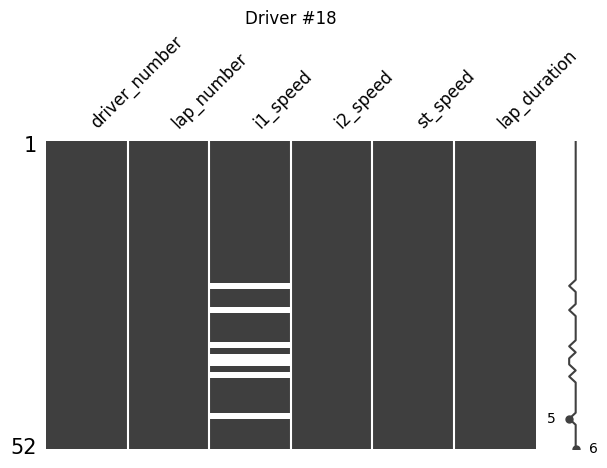


18 - Missing Value Summary:
i1_speed    7
dtype: int64


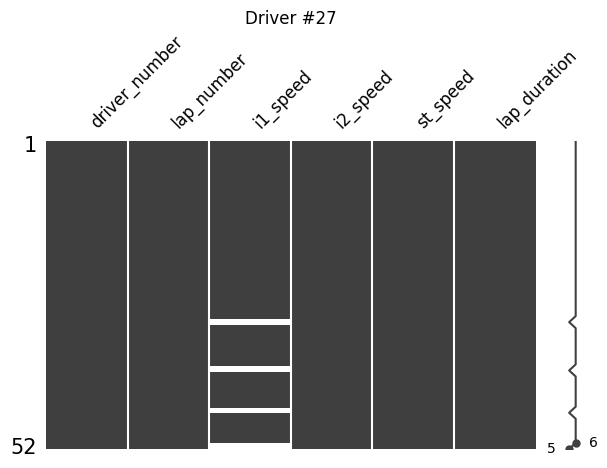


27 - Missing Value Summary:
i1_speed    4
dtype: int64


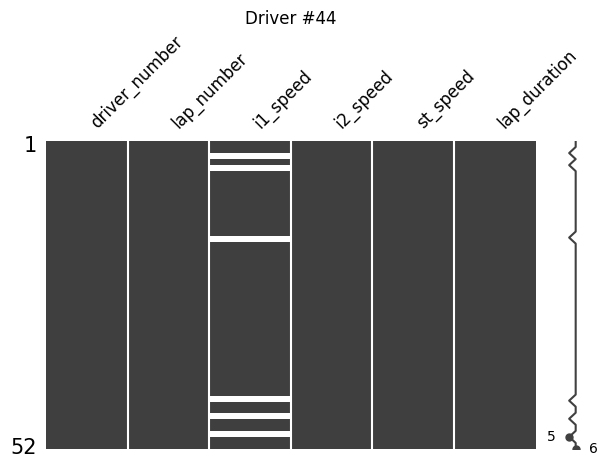


44 - Missing Value Summary:
i1_speed    6
dtype: int64


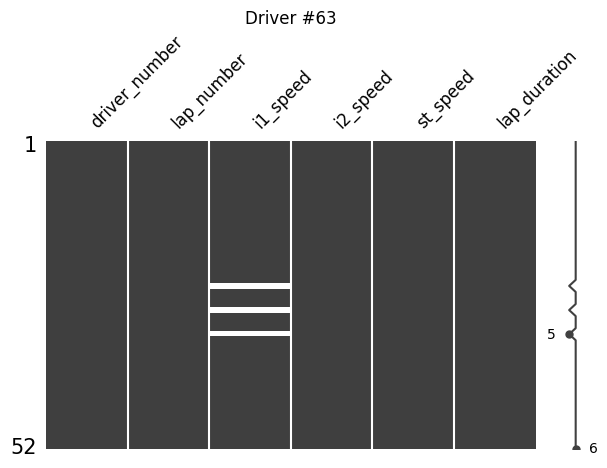


63 - Missing Value Summary:
i1_speed    3
dtype: int64


In [167]:
# The following provides a quick visual
import missingno as msno
import matplotlib.pyplot as plt

for driver, data in driver_laps_df.groupby('driver_number'):
    msno.matrix(data, figsize=(7, 4), fontsize=12)
    plt.title(f"Driver #{driver}")
    plt.show()
    
    print(f"\n{driver} - Missing Value Summary:")
    missing_counts = data.isnull().sum()
    print(missing_counts[missing_counts > 0])

Looks MAR and possibly MCAR. Could do a more comprehensive analysis and look at doing a regression on lap time for instance but likely worth very little time. We will now do some basic imputation of these missing values.

In [137]:
# Impute dataframe with basic interpolation. The groupby ensures each drivers data is separate
driver_laps_df['i1_speed'] = driver_laps_df.groupby('driver_number')['i1_speed'].transform(
    lambda x: x.interpolate(method='linear')
)

print(driver_laps_df['i1_speed'].info())
driver_laps_df

<class 'pandas.core.series.Series'>
RangeIndex: 208 entries, 0 to 207
Series name: i1_speed
Non-Null Count  Dtype  
--------------  -----  
208 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB
None


,driver_number,lap_number,i1_speed,i2_speed,st_speed,lap_duration
0,27,1,299.0,234,299,113.660
1,27,2,98.0,224,280,139.630
2,27,3,130.0,190,281,135.863
3,27,4,288.0,239,299,106.563
4,27,5,289.0,238,299,111.575
...,...,...,...,...,...,...
203,63,48,302.0,260,312,91.239
204,63,49,300.0,259,314,91.315
205,63,50,298.0,263,316,90.956
206,63,51,304.0,260,316,90.869


### 2.2. Driver's Stint Info

In [138]:
# Collect driver stint info
all_data = []
for driver_number in drivers:
    url = f"https://api.openf1.org/v1/stints?session_key={session}&driver_number={driver_number}"
    response = requests.get(url).json()    
    all_data.extend(response)

In [139]:
# Convert to DataFrame
driver_stint_df = pd.DataFrame(all_data)
driver_stint_df.head(n=3)

,meeting_key,session_key,stint_number,driver_number,lap_start,lap_end,compound,tyre_age_at_start
0,1277,9947,1,27,1,9,INTERMEDIATE,0
1,1277,9947,2,27,10,42,INTERMEDIATE,0
2,1277,9947,3,27,43,52,MEDIUM,0


In [140]:
# Drop irrelevant features
to_drop = ['meeting_key', 'session_key']
driver_stint_df.drop(columns=to_drop, inplace=True)
driver_stint_df.head(n=3)

,stint_number,driver_number,lap_start,lap_end,compound,tyre_age_at_start
0,1,27,1,9,INTERMEDIATE,0
1,2,27,10,42,INTERMEDIATE,0
2,3,27,43,52,MEDIUM,0


In [169]:
# Check all data is present
print(driver_stint_df.isnull().sum())
print(driver_stint_df.isna().sum())

stint_number         0
driver_number        0
lap_start            0
lap_end              0
compound             0
tyre_age_at_start    0
dtype: int64
stint_number         0
driver_number        0
lap_start            0
lap_end              0
compound             0
tyre_age_at_start    0
dtype: int64


### 2.3. Driver's Pit Info

In [197]:
# Collect driver pit info
all_data = []
for driver_number in drivers:
    url = f"https://api.openf1.org/v1/pit?session_key={session}&driver_number={driver_number}"
    response = requests.get(url).json()    
    all_data.extend(response)

In [198]:
# Convert to DataFrame
driver_pit_df = pd.DataFrame(all_data)
driver_pit_df.head(n=3)

,date,session_key,lap_number,lane_duration,stop_duration,pit_duration,meeting_key,driver_number
0,2025-07-06T14:22:11.077000+00:00,9947,9,29.736,3.7,29.736,1277,27
1,2025-07-06T15:26:13.413000+00:00,9947,42,29.952,4.6,29.952,1277,27
2,2025-07-06T14:16:33.376000+00:00,9947,6,29.125,2.7,29.125,1277,18


In [199]:
# Drop features
to_drop = ['meeting_key', 'session_key', 'date', 'pit_duration']
driver_pit_df.drop(columns=to_drop, inplace=True)
driver_pit_df.head(n=3)

,lap_number,lane_duration,stop_duration,driver_number
0,9,29.736,3.7,27
1,42,29.952,4.6,27
2,6,29.125,2.7,18


In [200]:
# Check all data is present
print(driver_pit_df.isnull().sum())
print(driver_pit_df.isna().sum())

lap_number       0
lane_duration    0
stop_duration    1
driver_number    0
dtype: int64
lap_number       0
lane_duration    0
stop_duration    1
driver_number    0
dtype: int64


In [207]:
# We're missing a pit. We will use the previous entries to estimate the stop_duration of the last pit.
driver_pit_df[driver_pit_df['driver_number'] == 18]
driver_pit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lap_number     9 non-null      int64  
 1   lane_duration  9 non-null      float64
 2   stop_duration  8 non-null      float64
 3   driver_number  9 non-null      int64  
dtypes: float64(2), int64(2)
memory usage: 420.0 bytes


We can calculate what the stop might be given the previous two valid pit rows.

`stop_duration + entry_exit_time = lane_duration`

`entry_exit_time = lane_duration - stop_duration`

e.g. lap 6 -> 2.7 + x = 29.125, x = 26.425

So our entry_exit_time gives us 26.425 (time in pit_lane but not in pit).

So all we need is the mean overhead and we can esimate what the pit would look like.

In [ ]:
# We could solve manually for just the two laps but I wanted to familiarse myself with python more

driver_18_df = driver_pit_df[
    (driver_pit_df['driver_number'] == 18) & 
    (~driver_pit_df.isna().any(axis=1))
] # get subset with driver #18 without NaN

mean_overhead = 0.0

for item in driver_18_df.itertuples():
    print(item)
    
    entry_exit_time = item.lane_duration + item.stop_duration # type: ignore
    print(entry_exit_time)
    

Pandas(Index=2, lap_number=6, lane_duration=29.125, stop_duration=2.7, driver_number=18)
31.825
Pandas(Index=3, lap_number=10, lane_duration=28.853, stop_duration=2.6, driver_number=18)
31.453000000000003


### 2.4. Combine ???

## 3. Final Merge
Now that we have all the data necessary for the investigation we can merge these dataframes into one larger and filter as required.